In [92]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import warnings #suppress warnings

warnings.filterwarnings("ignore")
%matplotlib inline

sns.set_style('whitegrid')

In [ ]:
jupyter nbconvert Jupyter\ Slides.ipynb --to slides --post serve

# Predicting Medical Appointment No Shows
>The following project explores a dataset from Brazil to determine to what extent we can predict whether patients will show up to their medical appointments as scheduled. There are 110,527 medical appointments with 14 associated variables. The target variable is ``no-show``, which records whether the patients show-up or are no-shows to their appointment.
> ### Scholarship variable explanation:
> Bolsa Família (Family Allowance) is a social welfare program of the Government of Brazil, part of the Fome Zero network of federal assistance programs. Bolsa Família provides financial aid to poor Brazilian families.
***
Patients failing to make their appointments can be quite problematic for medical professionals. From wasted personnel on staff to other patients, who were otherwise available, being scheduled for a later date, missed appointments can be quite disruptive for medical offices. In fact, missed appointments might also be disruptive to the absent patient's own good health! The question is: how do medical professionals combat missed appointments? Is there a way to predict ahead of time who is most likely to miss their appointments? The following analysis could serve as:
+ a method to help Brazilian medical offices anticipate appointment no-shows and subsequently determine whether intervention methods are cost effective.
+ a template for similar investigations across various locations, both inside and outside of Brazil, as well as in other professions where appointments are scheduled (with industry relevant variables).

In [93]:
no_show = pd.read_csv('/home/uzi/Downloads/KaggleV2-May-2016.csv')
no_show.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [94]:
no_show.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [95]:
def null_check(dataframe):
    # Missing value number and type detection
    for column_name in dataframe.columns:
        nan_list = []
        print("Problematic values: {}".format(column_name))
        for idx, value in enumerate(dataframe[column_name]):
            if pd.isnull(value):
                nan_list.append(str(value))
        # Determine percentage of rows that have null values
        num = dataframe[column_name].isnull().sum()*100/dataframe[column_name].isnull().count()
        print(
              len(nan_list), '/ {}%: '.format(round(num, 1)), set(nan_list)
             )

In [96]:
null_check(no_show)

Problematic values: PatientId
0 / 0.0%:  set()
Problematic values: AppointmentID
0 / 0.0%:  set()
Problematic values: Gender
0 / 0.0%:  set()
Problematic values: ScheduledDay
0 / 0.0%:  set()
Problematic values: AppointmentDay
0 / 0.0%:  set()
Problematic values: Age
0 / 0.0%:  set()
Problematic values: Neighbourhood
0 / 0.0%:  set()
Problematic values: Scholarship
0 / 0.0%:  set()
Problematic values: Hipertension
0 / 0.0%:  set()
Problematic values: Diabetes
0 / 0.0%:  set()
Problematic values: Alcoholism
0 / 0.0%:  set()
Problematic values: Handcap
0 / 0.0%:  set()
Problematic values: SMS_received
0 / 0.0%:  set()
Problematic values: No-show
0 / 0.0%:  set()


### There are no null values in our dataset.

In [97]:
no_show.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

> According to supplemental documentation provided with the data, the ``Handcap`` variable was intended to be a binary variable, so we'll convert all values 2 through 4 to a 1.

In [98]:
no_show['Handcap'] = np.where(no_show.Handcap > 0, 1, 0)
no_show.Handcap.unique()

array([0, 1])

### We'll now check for, and examine, any outliers in our lone continuous variable, $Age$. Let's plot our age variable.

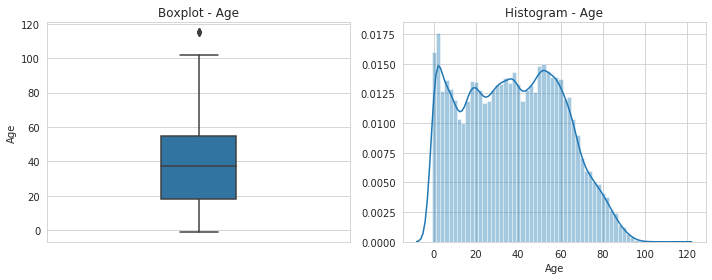

In [99]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.boxplot(y=no_show.Age, width=.25)
plt.title('Boxplot - Age')

plt.subplot(1,2,2)
# Two years per bin
sns.distplot(no_show.Age, bins=58)
plt.title('Histogram - Age')

plt.tight_layout()
plt.show()

> According to our boxplot, there are some outliers on the higher end of our ``Age`` variable. The distribution of ages seem to be fairly well represented across most twenty year ranges, showing a higher frequency around zero years and falling off after 60 years. Let's take a closer look.

In [100]:
z_score = zscore(no_show.Age)
for threshold in range(1,5):
    print(f'# of Outliers above {threshold} threshold: {len(np.where(z_score > threshold)[0])}')

# of Outliers above 1 threshold: 19762
# of Outliers above 2 threshold: 1746
# of Outliers above 3 threshold: 5
# of Outliers above 4 threshold: 0


In [101]:
# What is our lowest Age?
no_show[['Age']].sort_values('Age').head(3)

,Age
99832,-1
34218,0
102834,0


In [107]:
print(f'Outlier(s):\n{no_show.Age[np.where(z_score > 3)[0]]}')

Outlier(s):
63912    115
63915    115
68127    115
76284    115
97666    115
Name: Age, dtype: int64


In [108]:
print(no_show[['Age','PatientId']][no_show.Age == 115])

       Age     PatientId
63912  115  3.196321e+13
63915  115  3.196321e+13
68127  115  3.196321e+13
76284  115  3.196321e+13
97666  115  7.482346e+14


In [11]:
# Finding the PatientId for the negative Age value
print(no_show[['Age','PatientId']][no_show.Age == -1])

# Checking to see if the PatientID records a different age somewhere else in the df
# Converting column type to enable searching
no_show['PatientId'] = no_show.PatientId.astype(str)
print('\nTotal records matching PatientId: ')
print(no_show[['Age','PatientId']][no_show.PatientId == '465943158731293.0'].count()[0])

       Age     PatientId
99832   -1  4.659432e+14

Total records matching PatientId: 
1


> From the above cells, we can see that the patient with a negative age value only made one appointment, while on the high end, the observations come from, at most, two individuals. The *actual* age of the patients might hold important information, so I will only change the the negative age value to zero.

In [12]:
# Changing the negative age value to zero
no_show.Age[no_show.PatientId == '465943158731293.0'] = 0

# Converting the collumn values back to float
no_show['PatientId'] = no_show.PatientId.astype(float)

In [14]:
''' You can only run this cell ONCE'''

# Converting string values into binary categorical numbers
no_show['is_male'] = pd.get_dummies(no_show.Gender, drop_first=True)
no_show['is_noshow'] = pd.get_dummies(no_show['No-show'], drop_first=True)

del no_show['Gender'], no_show['No-show']

no_show.head(2)

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,is_male,is_noshow
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0


In [15]:
# Get string-based variable descriptions
no_show.describe(include='O')

,ScheduledDay,AppointmentDay,Neighbourhood
count,110527,110527,110527
unique,103549,27,81
top,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,JARDIM CAMBURI
freq,24,4692,7717


In [16]:
# Get numerical-based variable descriptions
no_show.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,is_male,is_noshow
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088883,0.098266,0.197246,0.071865,0.030400,0.020276,0.321026,0.350023,0.201933
std,2.560949e+14,7.129575e+04,23.110190,0.297675,0.397921,0.258265,0.171686,0.140942,0.466873,0.476979,0.401444
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Examining our categorical variables

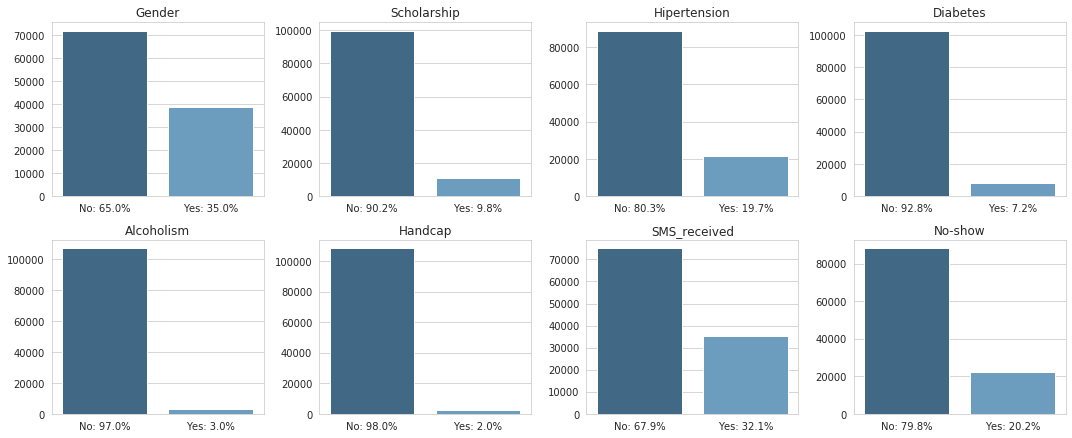

In [110]:
# Number of rows
row = no_show.shape[1]//4.1 + 1

plt.figure(figsize=(15,3*row))
i = 1
for name in no_show.columns:
    if no_show[name].nunique() == 2:
        plt.subplot(row, 4, i)
        ratio = no_show.groupby(name).size()/no_show.groupby(name).size().sum()
        ax = sns.barplot(x=no_show.groupby(name).count().index, y=no_show.groupby(name).size(), palette="Blues_d")
        ax.set_title(f"{name}")
        plt.xticks(ticks=[0,1], labels=[f'No: {round(ratio[0]*100,1)}%',f'Yes: {round(ratio[1]*100,1)}%'])
        plt.xlabel('')
        i+=1
plt.tight_layout()
plt.show()

> We have an unbalanced dataset with most observations from all our categorical variables falling into the 'No' category, including our target variable ``is_noshow``. What's interesting is that almost 80% of all our observations made their appointments. Therefore, going forward,<font color='blue'> 80% will be the baseline accuracy metric</font>, ie. the accuracy score we can expect running a naive model. However, since our data is unbalanced, there are other metrics which we'll prioritze when measuring the success of our models. More on that later.
### Now, let's take a look at the disparities between no-shows within each of the categorical variable above.

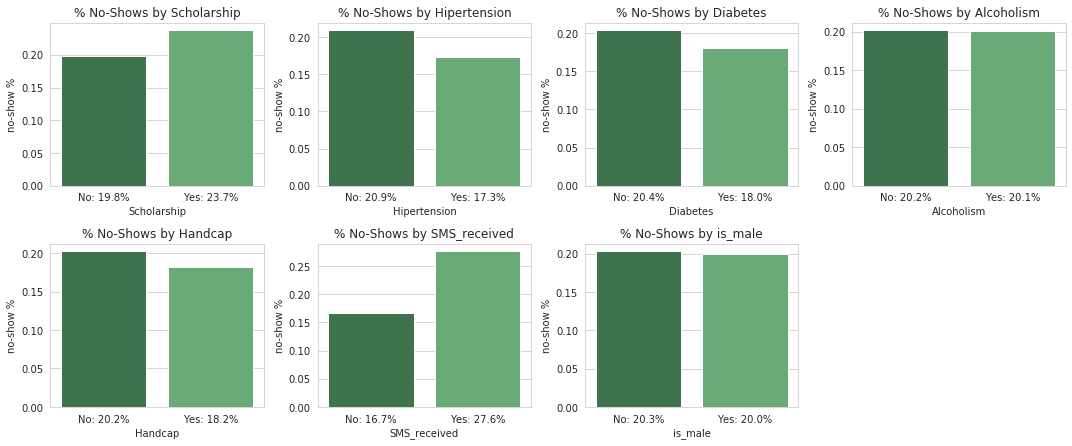

In [18]:
# Number of rows
row = no_show.shape[1]//4.1 + 1

plt.figure(figsize=(15,3*row))
i = 1
for name in no_show.columns:
    if no_show[name].nunique() == 2 and name != 'is_noshow':
        plt.subplot(row, 4, i)
        ratio = no_show[no_show['is_noshow'] == 1].groupby([name]).size()/no_show.groupby([name]).size()
        ax = sns.barplot(x=ratio.index, y=ratio, palette="Greens_d")
        ax.set_title(f"% No-Shows by {name}")
        plt.xticks(ticks=[0,1], labels=[f'No: {round(ratio[0]*100,1)}%',f'Yes: {round(ratio[1]*100,1)}%'])
        plt.xlabel(name)
        plt.ylabel('no-show %')
        i+=1
plt.tight_layout()
plt.show()

> Here, we get a better sense of how the categorical variables relate to our target variable. The cancellation ratios are very similar for ``Alcoholism`` and ``is_male`` to the overall no-show percentage of 20%, with the other variables showing slightly larger differences between *show-ups* and no-shows when the condition in question was present (irrespective of the other variables). The largest disparity occurs with ``SMS_received``, at a 10.9% difference, followed by ``Scholarship`` at 3.9%. These variables might lend the most predictive power towards determining whether a no-show will occur. From the ``is_noshow`` grouped means below, we can verify that the greatest difference occurs, among the binary variables, with the ``SMS_received`` variable.

In [19]:
# derive averages by group
no_show.groupby("is_noshow").mean()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,is_male
is_noshow,,,,,,,,,,
0,1.476845e+14,5.681137e+06,37.790076,0.093903,0.204392,0.073837,0.030417,0.020792,0.291334,0.351011
1,1.467523e+14,5.652259e+06,34.317667,0.115507,0.169004,0.064071,0.030333,0.018236,0.438371,0.346118


# Examining our Neighbourhood variable

Average show up rate per Neighborhood -  0.8


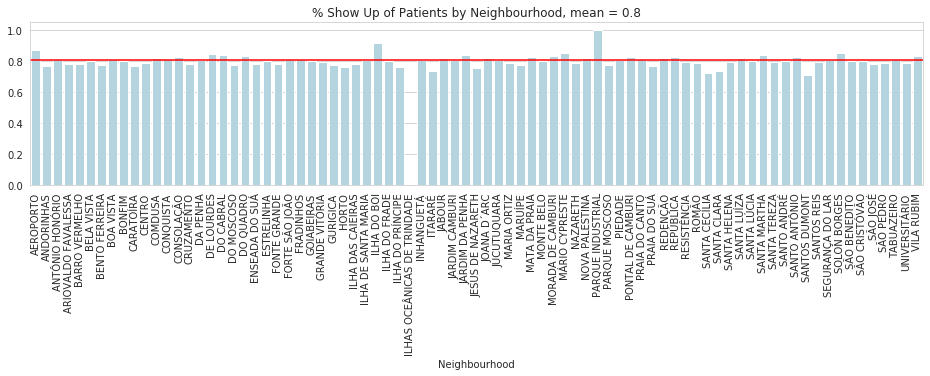

In [20]:
# Calculating the average show up rate per Neighborhood
df = pd.DataFrame(no_show[no_show['is_noshow'] == 0].groupby(['Neighbourhood']).size()/no_show.groupby(['Neighbourhood']).size())
print('Average show up rate per Neighborhood - ', round(df.mean()[0], 2))

ns_ratio = no_show[no_show['is_noshow'] == 0].groupby(['Neighbourhood']).size()/no_show.groupby(['Neighbourhood']).size()
plt.figure(figsize=(16,3))
plt.xticks(rotation=90)
ax = sns.barplot(x=ns_ratio.index, y=ns_ratio, color='lightblue')
ax.axhline(ns_ratio.mean(), ls='-', c='r')
ax.set_title(f'% Show Up of Patients by Neighbourhood, mean = {round(ns_ratio.mean(),2)}')
plt.show()

There are a couple of interesting observations here.

1. Most neighborhoods' show up percentages hover near the mean (indicated by the red line) and aligns with the aforementioned 80% arrival rate.
2. One neighborhood has a perfect show up rate.
3. One neghborhood has a zero percent show up rate.

Let's take a closer look at those two unique neighborhood situations.

In [21]:
no_show[no_show['Neighbourhood'].isin(['ILHAS OCEÂNICAS DE TRINDADE','PARQUE INDUSTRIAL'])].sort_values(by='AppointmentID')

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,is_male,is_noshow
48754,5.349869e+11,5583947,2016-04-14T12:25:43Z,2016-05-13T00:00:00Z,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,0,1
48765,7.256430e+12,5583948,2016-04-14T12:26:13Z,2016-05-13T00:00:00Z,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,0,1
75199,8.255992e+12,5663947,2016-05-05T10:48:59Z,2016-05-05T00:00:00Z,17,PARQUE INDUSTRIAL,0,0,0,0,0,0,0,0


> Although the ``Neighbourhood`` variable doesn't appear as if it will have much predictive power due to the show up rate for each neighborhood hovering near the mean show up rate of about 80%, the two neighborhood's show up rates are determined by only a couple observations and are unlikely to hold much predictive power on their own. 

# Feature Extraction

In [23]:
no_show[['ScheduledDay','AppointmentDay']].head()

,ScheduledDay,AppointmentDay
0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z
1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z
2,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z
3,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z
4,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z


In [24]:
def TimeOfDay(time):
    time = time.replace('Z','')
    time = time.split('T')
    time.pop(0)
    time = time[0].split(':')
    time = int(time[0]) + int(time[1])/60 + int(time[2])/360
    return round(time, 2)

In [25]:
# Creates a ['YearNo', 'MonthNo', 'DayNo'] list for each date entry
def date_list(date):
    date = date.split('T')
    date.pop()
    date = date[0].split('-')
    return date

In [26]:
# returns (YearNo, DaysInYear) tuple
def DaysInYear(date_list):
    days = []
    YearNo, MonthNo, DayNo = date_list[0], date_list[1], date_list[2]
    MonthNo = int(MonthNo)
    while MonthNo > 1:
        MonthNo-=1
        if MonthNo in [1,3,5,7,8,10,12]:
            days.append(31)
        elif MonthNo == 2:
            days.append(29)
        elif MonthNo in [4,6,9,11]:
            days.append(30)
    days.append(int(DayNo))
    days = sum(days)

    return days

### Let's convert the scheduled and appointment dates to which day of the year the occurred. We'll also create a column indicating the hour of the day the appointment was made.

In [27]:
# Converting the original date formats to the desired days
no_show['TimeOfDay'] = no_show.ScheduledDay.apply(TimeOfDay)

no_show['Scheduled'] = no_show.ScheduledDay.apply(date_list)
no_show['Appointment'] = no_show.AppointmentDay.apply(date_list)

no_show['Scheduled'] = no_show.Scheduled.apply(DaysInYear)
no_show['Appointment'] = no_show.Appointment.apply(DaysInYear)

no_show[['Scheduled','Appointment', 'TimeOfDay']].head(3)

,Scheduled,Appointment,TimeOfDay
0,120,120,18.66
1,120,120,16.21
2,120,120,16.33


In [28]:
# Create temporary Year_Sched and Year_Appt columns
no_show['Year_Sched'] = np.where(no_show.ScheduledDay.str.startswith('2015'), 2015, 2016)
no_show['Year_Appt'] = np.where(no_show.AppointmentDay.str.startswith('2015'), 2015, 2016)


# Calculating days until appointment column, ie. days between schedule day and appt day
no_show['DaysTilAppt'] = np.where(no_show.Year_Appt == no_show.Year_Sched, 
                                  no_show.Appointment - no_show.Scheduled, 
                                  no_show.Appointment + 365 - no_show.Scheduled)

# Delete temporary columns
del no_show['Year_Appt'], no_show['Year_Sched']

no_show.head(3)

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,is_male,is_noshow,TimeOfDay,Scheduled,Appointment,DaysTilAppt
0,2.987250e+13,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0,18.66,120,120,0
1,5.589978e+14,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,16.21,120,120,0
2,4.262962e+12,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,0,16.33,120,120,0


In [29]:
no_show[no_show.DaysTilAppt < 0]['DaysTilAppt']

27033   -1
55226   -1
64175   -1
71533   -6
72362   -1
Name: DaysTilAppt, dtype: int64

> Erroneous date entries for ``AppointmentDay`` and ``ScheduleDay`` resulted in a handful of negative days between scheduling and appointment. Since only five entries have erroneous date entries, we'll change their negative values to zero

In [30]:
no_show.DaysTilAppt = no_show.DaysTilAppt.apply(lambda x: 0 if x < 0 else x)

# Returns an empty dataframe
no_show[no_show.DaysTilAppt < 0]

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,is_male,is_noshow,TimeOfDay,Scheduled,Appointment,DaysTilAppt


In [31]:
print(f'The earliest appointment was at {no_show.Appointment.min()} days')
print(f'The latest appointment was at {no_show.Appointment.max()} days')

The earliest appointment was at 120 days
The latest appointment was at 160 days


> Since all the appointments occurred within a 40 day window, the ``Scheduled`` and ``Appointment`` variables may not hold much predictive power when our model is tested with data from other times of the year. Instead, we try to capture a relationship between the two with the previously created``DaysTilAppt`` feature that might maintain its relevance regardless the time of year.

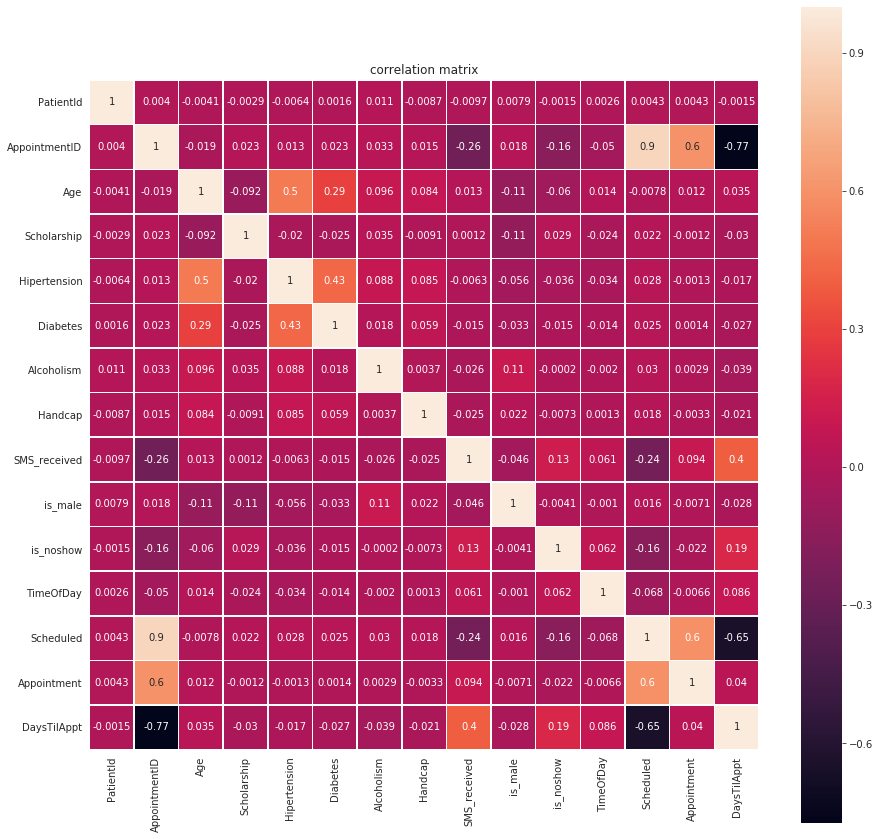

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(no_show.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()

> Interestingly, there seems to be a strong correlation between ``AppointmentID`` and ``Appointment``, ``Scheduled`` and ``DaysTilAppt``, indicating that it is not just a randomly generated variable, but somehow captures some information contained in the latter variables. This probably explains why it also has one of the highest correlations with the target variable out of any of the original variables. Since we weren't given any insight into how ``AppointmentID`` was generated in the data documentation, it might also capture information from other sources that are not a part of this dataset. Therefore, we can exclude it as a model feature, yet still capture some of its prediction power from a combination of one or more of the ``Appointment``, ``Scheduled`` and ``DaysTilAppt`` features. We can also see that ``Age`` significantly correlates with both ``Hipertension`` and ``Diabetes``, while ``Hipertensiopn`` and ``Diabetes`` correlate with each other. However, since none of them have a high correlation with our target variable ``is_noshow``, we'll see how much predictive power they ultimately hold.

In [33]:
# Creating our features and target feature
X = no_show.drop(['is_noshow','Neighbourhood','ScheduledDay','AppointmentDay','PatientId','AppointmentID'], axis=1)
Y = no_show.is_noshow

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

print("The number of observations in training set is {}".format(y_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 88421
The number of observations in test set is 22106


> ### A quick word on the parameter values: 
The hyperparameter ranges, for the hyperparameters included in the models below, were decided upon by several trials in the build up to the final model, where the highest performing values, or ranges, were honed in upon. You will see these parameters used in the upcoming models (see footnote for hyperparameter definitions)[<sub>1</sub>](#fn1).

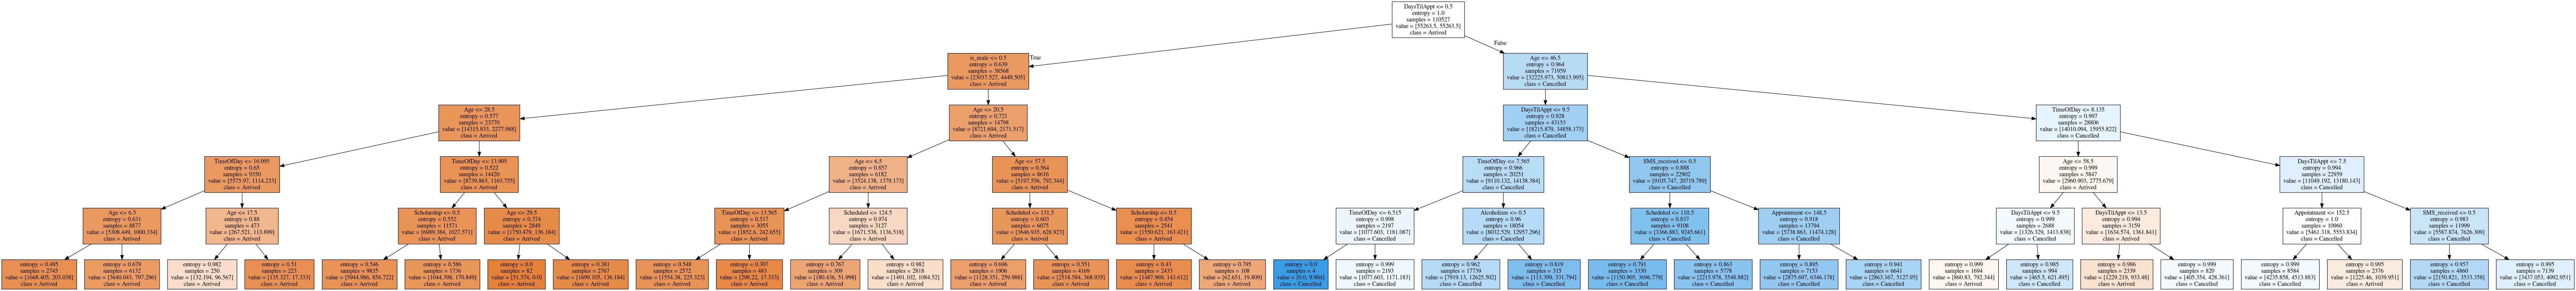

In [42]:
# This is the model we'll be using.
from sklearn import tree

# For displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=6,
    max_depth=5,
    class_weight='balanced',
    random_state=5
)
decision_tree.fit(X, Y)

# Render our tree. ########### class_weight balanced data creates fractional class values #############
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Arrived', 'Cancelled'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

> Since our data is unbalnced, with and 80/20 split between patients who arrived to their appointments and no-shows, respectively, we first balanced our data with class weights. At first glance, it appears as if our decision tree has a good classification split right from the root node. ``DaysTilAppt $<= 0.5`` seems to be the rule that best classifies our observations, with same-day appointments being the greatest predictor of a patient's arrival. We can confirm that with the built-in ``feature_importance_`` method for decision tree classifiers, below.

In [43]:
print("Feature Importance:\n")
for i, name in enumerate(X.columns):
    print(f"{name} - {round(decision_tree.feature_importances_[i], 3)}")

Feature Importance:

Age - 0.109
Scholarship - 0.001
Hipertension - 0.0
Diabetes - 0.0
Alcoholism - 0.002
Handcap - 0.0
SMS_received - 0.011
is_male - 0.008
TimeOfDay - 0.012
Scheduled - 0.004
Appointment - 0.003
DaysTilAppt - 0.85


# Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm # show progress bar
import time # time random searches

In [45]:
########################################################################
#########    Creating a function in order to quickly call upon    ######
#########         the model with different features  while        ######
#########        cycling through different model parameters       ######
########################################################################

def LogReg_RandomSearch(X, Y,C=[1, .5, .25, .01],
                             max_iter=[2000, 3000, 4000],
                             class_weight=['balanced']
                       ):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    logreg_hyperparams = dict(
                              C = C,
                              max_iter = max_iter,
                              class_weight = class_weight
                              )

    logreg_hyper_table = list()

    # Timed for loop...start the clock!
    start_time = time.time()
    for trial in tqdm(range(10), position=0):
        params = dict()
        for k, v in logreg_hyperparams.items():
            i = np.random.randint(len(v))
            params[k] = v[i]
        #print(params)
        logreg = LogisticRegression(**params)
        logreg.fit(X_train, y_train)
        y_pred_train = logreg.predict(X_train)
        y_pred_test = logreg.predict(X_test)
        params['train_precision'] = precision_score(y_train, y_pred_train)
        params['test_precision'] = precision_score(y_test, y_pred_test)
        params['train_recall'] = recall_score(y_train, y_pred_train)
        params['test_recall'] = recall_score(y_test, y_pred_test)
        params['train_acc'] = logreg.score(X_train, y_train)
        params['test_acc'] = logreg.score(X_test, y_test)
        params['train_f1'] = 2 * (params['train_precision'] * params['train_recall'])/(params['train_precision'] + params['train_recall'])
        params['test_f1'] = 2 * (params['test_precision'] * params['test_recall'])/(params['test_precision'] + params['test_recall'])
        
        # Store our parameters and score in a dataframe
        logreg_hyper_table.append(params)

        end_time = time.time()

    print(f'Execution time: {round(end_time - start_time, 2)} seconds')
    logreg_hyper_table = pd.DataFrame(data=logreg_hyper_table)
    return logreg_hyper_table.sort_values(by='test_recall', ascending=False)

In [46]:
# Define our features and target variable
X = no_show.drop(['is_noshow','Neighbourhood','ScheduledDay','AppointmentDay','PatientId','AppointmentID'], axis=1)
Y = no_show.is_noshow

# Call the Logistic Regression function
logreg_hyper_df = LogReg_RandomSearch(X,Y)
logreg_hyper_df.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])

100%|██████████| 10/10 [00:15<00:00,  1.39s/it]

Execution time: 15.82 seconds


,C,class_weight,max_iter,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
2,0.5,balanced,3000,0.664887,0.401938,0.311374,0.566788,0.666736,0.41162,0.321064,0.573327
1,0.25,balanced,3000,0.66531,0.401402,0.311329,0.564815,0.66786,0.412062,0.321883,0.572437
4,0.25,balanced,2000,0.66531,0.401402,0.311329,0.564815,0.66786,0.412062,0.321883,0.572437
7,0.25,balanced,2000,0.66531,0.401402,0.311329,0.564815,0.66786,0.412062,0.321883,0.572437
8,0.25,balanced,4000,0.66531,0.401402,0.311329,0.564815,0.66786,0.412062,0.321883,0.572437
9,0.25,balanced,2000,0.66531,0.401402,0.311329,0.564815,0.66786,0.412062,0.321883,0.572437
3,1,balanced,3000,0.665702,0.401296,0.311478,0.563904,0.667589,0.411918,0.321667,0.572564
5,1,balanced,4000,0.665702,0.401296,0.311478,0.563904,0.667589,0.411918,0.321667,0.572564
0,0.01,balanced,3000,0.666244,0.401039,0.311633,0.562386,0.668817,0.412303,0.32252,0.571356
6,0.01,balanced,4000,0.666244,0.401039,0.311633,0.562386,0.668817,0.412303,0.32252,0.571356


> None of the model parameter combinations were able to perform above our previous baseline of 80% accuracy. However, let's say, for instance, that a medical office was more concerned with targeting as many no-shows as possible, even if it means targeting some *show-ups* in the process. Depending on what intervention measures they choose to employ to combat no-shows, as well as the associated costs, the best **recall** (the ratio of predicted positives to actual positives, also known as the **True Positive Rate**) or **f1 score** (the reciprocal of the arithmetic mean of recall and precision)[<sub>2</sub>](#fn2) might better identify the preferred parameters for this model than the accuracy score alone. Several parameter combinations score over 0.5 on ``test_recall`` in our logistic regression model, which means over 50% of all cancellations are being identified.

> This model takes some time to run, though. At the moment, we're using all of our categorical besides ``Neighbourhood``, the ID features and the Schedule/Appointment variables from which we've extracted our ``Schedule``, ``Appointment``, ``TimeOfDay`` and ``DaysTilAppt`` features. We've seen previously, from our correlation heatmap, that our target variable only shares a small correlation with a handful of features, anyway. So, let's reduce our model features and see how the model performs.

In [51]:
X = no_show[['Age','TimeOfDay','SMS_received','DaysTilAppt']]
Y = no_show.is_noshow

logreg_hyper_df2 = LogReg_RandomSearch(X,Y)
logreg_hyper_df2.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])

100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

Execution time: 2.43 seconds


,C,class_weight,max_iter,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
4,1,balanced,4000,0.664706,0.398767,0.309728,0.559654,0.666878,0.409052,0.31992,0.567033
7,1,balanced,2000,0.664706,0.398767,0.309728,0.559654,0.666878,0.409052,0.31992,0.567033
1,0.25,balanced,3000,0.664646,0.398659,0.309644,0.559502,0.666878,0.409052,0.31992,0.567033
2,0.25,balanced,3000,0.664646,0.398659,0.309644,0.559502,0.666878,0.409052,0.31992,0.567033
3,0.5,balanced,4000,0.664646,0.398659,0.309644,0.559502,0.666865,0.409043,0.319908,0.567033
5,0.25,balanced,4000,0.664646,0.398659,0.309644,0.559502,0.666878,0.409052,0.31992,0.567033
6,0.25,balanced,3000,0.664646,0.398659,0.309644,0.559502,0.666878,0.409052,0.31992,0.567033
9,0.5,balanced,2000,0.664646,0.398659,0.309644,0.559502,0.666865,0.409043,0.319908,0.567033
0,0.01,balanced,2000,0.6654,0.399068,0.310232,0.559199,0.667408,0.409275,0.320313,0.566652
8,0.01,balanced,3000,0.6654,0.399068,0.310232,0.559199,0.667408,0.409275,0.320313,0.566652


> With this search we see a slight downtick in ``test_recall`` and ``test_f1`` scores but a significant improvement in execution time despite the runtime on the first search not being all that prohibitive. Nonetheless, let's reduce our features a bit, to just the two highest correlating features, and see what we get.

In [91]:
X = no_show[['SMS_received','DaysTilAppt']]
Y = no_show.is_noshow

logreg_hyper_df3 = LogReg_RandomSearch(X,Y)
logreg_hyper_df3.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])

100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

Execution time: 2.02 seconds


,C,class_weight,max_iter,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
0,1,balanced,3000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
1,0.25,balanced,4000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
2,0.5,balanced,2000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
3,0.25,balanced,3000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
4,0.5,balanced,3000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
5,0.25,balanced,4000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
6,0.01,balanced,2000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
7,0.5,balanced,3000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
8,0.01,balanced,4000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431
9,0.01,balanced,4000,0.634066,0.390863,0.292004,0.590923,0.636995,0.399726,0.301101,0.594431


>Our random search model executed in about the same time with these two features as it did with features from our second search. It also outperformed both of our previous searches in ``test_recall`` score while maintaining only a slight downtick in ``test_f1`` score compared to the original features we modeled.

# Random Forest

In [53]:
from sklearn import ensemble

In [54]:
########################################################################
#########    Creating a function in order to quickly call upon    ######
#########         the model with different features  while        ######
#########        cycling through different model parameters       ######
########################################################################

def RandForest_RandomSearch(X, Y, criterion=['gini', 'entropy'],
                                  max_depth=[3, 4, 5],
                                  n_estimators=[50, 100, 250],
                                  class_weight=['balanced', 'balanced_subsample']
                           ):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    rfc_hyperparams = dict(
                           criterion = criterion,
                           max_depth = max_depth,
                           n_estimators = n_estimators,
                           class_weight = class_weight
                           )

    rfc_hyper_table = list()

    # Timed for loop...start the clock!
    start_time = time.time()
    for trial in tqdm(range(10), position=0):
        params = dict()
        for k, v in rfc_hyperparams.items():
            i = np.random.randint(len(v))
            params[k] = v[i]
        #print(params)
        rfc = ensemble.RandomForestClassifier(**params)
        rfc.fit(X_train, y_train)
        y_pred_train = rfc.predict(X_train)
        y_pred_test = rfc.predict(X_test)
        params['train_precision'] = precision_score(y_train, y_pred_train)
        params['test_precision'] = precision_score(y_test, y_pred_test)
        params['train_recall'] = recall_score(y_train, y_pred_train)
        params['test_recall'] = recall_score(y_test, y_pred_test)
        params['train_acc'] = rfc.score(X_train, y_train)
        params['test_acc'] = rfc.score(X_test, y_test)
        params['train_f1'] = 2 * (params['train_precision'] * params['train_recall'])/(params['train_precision'] + params['train_recall'])
        params['test_f1'] = 2 * (params['test_precision'] * params['test_recall'])/(params['test_precision'] + params['test_recall'])
        
        # Store our parameters and score in a dataframe
        rfc_hyper_table.append(params)

        end_time = time.time()

    print(f'Execution time: {round(end_time - start_time, 2)} seconds')
    rfc_hyper_table = pd.DataFrame(data=rfc_hyper_table)
    return rfc_hyper_table.sort_values(by='test_recall', ascending=False)

### Let's run the previous three collections of features on the random forest model.

In [55]:
X = no_show.drop(['is_noshow','Neighbourhood','ScheduledDay','AppointmentDay','PatientId','AppointmentID'], axis=1)
Y = no_show.is_noshow

# Call the Random Forest function
rand_forest_df = RandForest_RandomSearch(X,Y)
rand_forest_df.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])

100%|██████████| 10/10 [00:55<00:00,  5.23s/it]

Execution time: 55.49 seconds


,class_weight,criterion,max_depth,n_estimators,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
8,balanced_subsample,entropy,3,250,0.544015,0.432901,0.287486,0.875987,0.547862,0.441546,0.294811,0.879092
7,balanced_subsample,gini,5,100,0.547513,0.434281,0.288903,0.874165,0.551985,0.444216,0.29703,0.880554
4,balanced,entropy,4,100,0.546548,0.432861,0.287994,0.870978,0.551055,0.443026,0.296241,0.878139
3,balanced,gini,3,250,0.553424,0.432861,0.289468,0.857772,0.557414,0.442113,0.297237,0.862501
6,balanced,gini,5,100,0.560542,0.4355,0.292365,0.853218,0.566009,0.446335,0.301331,0.860339
1,balanced,entropy,3,50,0.554932,0.430545,0.288649,0.846843,0.559999,0.44122,0.297404,0.854364
9,balanced,entropy,4,50,0.559697,0.432966,0.290919,0.846084,0.564006,0.44287,0.299163,0.852266
0,balanced_subsample,entropy,4,250,0.561175,0.433483,0.291512,0.845021,0.566888,0.445261,0.301025,0.854873
5,balanced_subsample,gini,3,250,0.561446,0.432707,0.29119,0.841834,0.566319,0.442447,0.299519,0.846291
2,balanced_subsample,gini,5,100,0.567749,0.435197,0.293895,0.838191,0.57264,0.446535,0.303074,0.84788


> There are some attractive ``test_recall`` scores among these trials, with each eclipsing 0.82. We're also seeing an improvement in the ``test_f1`` scores. We do see some low precision scores, however, and this is where a medical office's no-show intervention methods and costs would come into play. A doctor's office would have to determine whether the costs of a no-show outweigh the cost of wasting intervention methods on patients who have a high likelihood of showing up. Also, although this model vastly outperforms the logistic model from before in ``test_recall`` score, it takes longer time to run. Now let's see if a reduced predictor set can approximate these improved results while maintaining or improving speed.

In [56]:
X = no_show[['Age','TimeOfDay','SMS_received','DaysTilAppt']]
Y = no_show.is_noshow

rand_forest_df2 = RandForest_RandomSearch(X,Y)
rand_forest_df2.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])

100%|██████████| 10/10 [00:58<00:00,  7.79s/it]

Execution time: 58.58 seconds


,class_weight,criterion,max_depth,n_estimators,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
8,balanced,gini,3,250,0.52773,0.431579,0.283608,0.902398,0.531124,0.43977,0.290447,0.905092
4,balanced_subsample,entropy,4,50,0.547785,0.434172,0.288907,0.873254,0.55183,0.444363,0.297067,0.881381
2,balanced,entropy,4,50,0.553424,0.433165,0.289619,0.858834,0.559469,0.446048,0.299633,0.87229
1,balanced_subsample,entropy,4,50,0.555626,0.432942,0.289993,0.853825,0.562687,0.446234,0.300483,0.866569
6,balanced_subsample,entropy,4,250,0.557616,0.433257,0.290593,0.851093,0.564549,0.446853,0.301229,0.865044
0,balanced_subsample,gini,4,50,0.559456,0.433711,0.291233,0.84912,0.566164,0.447517,0.301941,0.864154
5,balanced,entropy,5,50,0.56974,0.436154,0.294844,0.837583,0.576634,0.450207,0.305866,0.852521
3,balanced,gini,5,250,0.568594,0.435054,0.294027,0.836066,0.575626,0.449729,0.305376,0.852902
9,balanced,gini,5,250,0.569529,0.435453,0.294448,0.83561,0.576233,0.449825,0.305579,0.852012
7,balanced_subsample,gini,5,250,0.572936,0.436333,0.295711,0.831967,0.579619,0.450552,0.306813,0.847689


> The reduced features successfully approximate the previous model's scores, if not exceeding them. Next, we'll see if the two features from before can perform as well as it's bigger counterparts.

In [65]:
X = no_show[['SMS_received','DaysTilAppt']]
Y = no_show.is_noshow

rand_forest_df3 = RandForest_RandomSearch(X,Y)
rand_forest_df3.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])

100%|██████████| 10/10 [00:41<00:00,  4.83s/it]

Execution time: 41.07 seconds


,class_weight,criterion,max_depth,n_estimators,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
0,balanced,gini,4,100,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
2,balanced,entropy,4,250,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
3,balanced_subsample,gini,3,100,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
4,balanced_subsample,entropy,3,100,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
6,balanced,gini,4,100,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
7,balanced,gini,4,100,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
8,balanced_subsample,gini,4,100,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
9,balanced_subsample,entropy,4,250,0.516934,0.430896,0.281288,0.920461,0.518974,0.437247,0.286859,0.919077
5,balanced_subsample,entropy,5,250,0.517054,0.430795,0.281259,0.919854,0.519297,0.437378,0.286985,0.91895
1,balanced_subsample,gini,5,100,0.517054,0.430715,0.281218,0.919551,0.519323,0.43734,0.286971,0.918759


### Cross validation

In [66]:
rfc = ensemble.RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', max_depth=3, 
                                      n_estimators=100)
cross_val_score(rfc, X, Y, cv=5, scoring='recall')

array([0.93839606, 0.95766129, 0.86623348, 0.91218638, 0.92293907])

> Again, the simplest model outperforms its larger counterparts, consistently testing above 0.91 even at a mere max-depth of three. The low tree depth is a form of regularization, meaning that, along with the consistency between training and testing scores, our model is performing as intended (high recall) without overfitting. You can see from our cross validation scores that if we take the hyperparameters from one of our top performing hyperparameter combinations, we get high recall scores across the board.

# Support Vector Machines

In [67]:
from sklearn.svm import SVC

In [72]:
########################################################################
#########    Creating a function in order to quickly call upon    ######
#########         the model with different features  while        ######
#########        cycling through different model parameters       ######
########################################################################

def SVC_RandomSearch(X, Y, C=[1, .5, .25, .01],
                           kernel=['linear'],
                           class_weight=['balanced']
                     ):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    svc_hyperparams = dict(
                           C=C,
                           kernel = kernel,
                           class_weight = class_weight
                           )

    svc_hyper_table = list()

    # Timed for loop...start the clock!
    start_time = time.time()
    for trial in tqdm(range(10), position=1):
        params = dict()
        for k, v in svc_hyperparams.items():
            i = np.random.randint(len(v))
            params[k] = v[i]
        svc = SVC(**params)
        svc.fit(X_train, y_train)
        y_pred_train = svc.predict(X_train)
        y_pred_test = svc.predict(X_test)
        params['train_precision'] = precision_score(y_train, y_pred_train)
        params['test_precision'] = precision_score(y_test, y_pred_test)
        params['train_recall'] = recall_score(y_train, y_pred_train)
        params['test_recall'] = recall_score(y_test, y_pred_test)
        params['train_acc'] = svc.score(X_train, y_train)
        params['test_acc'] = svc.score(X_test, y_test)
        params['train_f1'] = 2 * (params['train_precision'] * params['train_recall'])/(params['train_precision'] + params['train_recall'])
        params['test_f1'] = 2 * (params['test_precision'] * params['test_recall'])/(params['test_precision'] + params['test_recall'])
        params['model_class'] = 'sklearn.svm.SVC'
        # Store our parameters and score in a dataframe
        svc_hyper_table.append(params)

        end_time = time.time()
        svc_hyper_df = pd.DataFrame(data=svc_hyper_table)
        with open('svc_hyper_df.csv', mode='wt') as fout:
            svc_hyper_df.to_csv(fout,index=False)

    print(f'Execution time: {round(end_time - start_time, 2)} seconds')
    return svc_hyper_df.sort_values(by='test_recall', ascending=False)

### In the interest of saving time, let's only run the support vector classifier model on the minimized, two feature set.

In [73]:
X = no_show[['SMS_received','DaysTilAppt']]
Y = no_show.is_noshow

# Call the Support Vector Classifier function
svc_hyper_df = SVC_RandomSearch(X,Y)
svc_hyper_df.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])


100%|██████████| 10/10 [53:10<00:00, 251.83s/it]

Execution time: 3190.07 seconds


,C,class_weight,kernel,model_class,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
1,0.01,balanced,linear,sklearn.svm.SVC,0.636931,0.378504,0.286787,0.556466,0.638636,0.386967,0.295364,0.560931
7,0.01,balanced,linear,sklearn.svm.SVC,0.636931,0.378504,0.286787,0.556466,0.638636,0.386967,0.295364,0.560931
8,0.01,balanced,linear,sklearn.svm.SVC,0.636931,0.378504,0.286787,0.556466,0.638636,0.386967,0.295364,0.560931
9,0.01,balanced,linear,sklearn.svm.SVC,0.636931,0.378504,0.286787,0.556466,0.638636,0.386967,0.295364,0.560931
0,0.25,balanced,linear,sklearn.svm.SVC,0.637896,0.374863,0.285284,0.546448,0.639502,0.384237,0.294344,0.553175
4,0.25,balanced,linear,sklearn.svm.SVC,0.637896,0.374863,0.285284,0.546448,0.639502,0.384237,0.294344,0.553175
2,0.5,balanced,linear,sklearn.svm.SVC,0.63865,0.373195,0.284722,0.541439,0.640278,0.382261,0.29367,0.547391
3,1,balanced,linear,sklearn.svm.SVC,0.63865,0.373195,0.284722,0.541439,0.640278,0.382261,0.29367,0.547391
5,0.5,balanced,linear,sklearn.svm.SVC,0.63865,0.373195,0.284722,0.541439,0.640278,0.382261,0.29367,0.547391
6,0.5,balanced,linear,sklearn.svm.SVC,0.63865,0.373195,0.284722,0.541439,0.640278,0.382261,0.29367,0.547391


> This model took an exceedingly long time to run and it is out worst performing model yet. Let's try a gradient boosting model

In [213]:
# To retrieve the last variable created
# svc_hyper_df = _

# to_csv: svc_hyper_df = pd.DataFrame(data=svc_hyper_table)
with open('svc_hyper_df.csv', mode='wt') as fout:
    svc_hyper_df.to_csv(fout,index=False)

# Gradient Boosting

GB builds an additive model in a
forward stage-wise fashion; it allows for the optimization of
arbitrary differentiable loss functions. In each stage ``n_classes_``
regression trees are fit on the negative gradient of the
binomial or multinomial deviance loss function. Binary classification
is a special case where only a single regression tree is induced.

In [227]:
########################################################################
#########    Creating a function in order to quickly call upon    ######
#########         the model with different features  while        ######
#########        cycling through different model parameters       ######
########################################################################

def GBoost_RandomSearch(X, Y, loss = ['deviance', 'exponential'],
                              learning_rate = [.5, .25, .1, .01],
                              #criterion = ['friedman_mse'],
                              max_depth = [3, 4, 5],
                              max_features = ['sqrt'],
                              n_estimators = [50, 100, 250]
                       ):
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    gboost_hyperparams = dict(
                              loss = loss,
                              learning_rate = learning_rate,
                              #criterion = criterion,
                              max_depth = max_depth,
                              max_features = max_features,
                              n_estimators = n_estimators
                              )

    gboost_hyper_table = list()

    # Timed for loop...start the clock!
    start_time = time.time()
    for trial in tqdm(range(10)):
        params = dict()
        for k, v in gboost_hyperparams.items():
            i = np.random.randint(len(v))
            params[k] = v[i]
        #print(params)
        gboost = ensemble.GradientBoostingClassifier(**params)
        gboost.fit(X_train, y_train)
        y_pred_train = gboost.predict(X_train)
        y_pred_test = gboost.predict(X_test)
        params['train_precision'] = precision_score(y_train, y_pred_train)
        params['test_precision'] = precision_score(y_test, y_pred_test)
        params['train_recall'] = recall_score(y_train, y_pred_train)
        params['test_recall'] = recall_score(y_test, y_pred_test)
        params['train_acc'] = gboost.score(X_train, y_train)
        params['test_acc'] = gboost.score(X_test, y_test)
        params['train_f1'] = 2 * (params['train_precision'] * params['train_recall'])/(params['train_precision'] + params['train_recall'])
        params['test_f1'] = 2 * (params['test_precision'] * params['test_recall'])/(params['test_precision'] + params['test_recall'])
        
        # Store our parameters and score in a dataframe
        gboost_hyper_table.append(params)

        end_time = time.time()
        gboost_hyper_df = pd.DataFrame(data=gboost_hyper_table)
        with open('gboost_hyper_df.csv', mode='wt') as fout:
            gboost_hyper_df.to_csv(fout,index=False)

    print(f'Execution time: {round(end_time - start_time, 2)} seconds')
    return gboost_hyper_df.sort_values(by='test_recall', ascending=False)

In [228]:
X = no_show[['SMS_received','DaysTilAppt']]
Y = no_show.is_noshow

# Call the Gradient Boost function
gboost_hyper_df = GBoost_RandomSearch(X,Y)
gboost_hyper_df.style.apply(lambda x: ['background: yellow' if x.name == 'test_recall' else '' for i in x])


100%|██████████| 10/10 [00:21<00:00,  1.92s/it]

Execution time: 21.4 seconds


,learning_rate,loss,max_depth,max_features,n_estimators,test_acc,test_f1,test_precision,test_recall,train_acc,train_f1,train_precision,train_recall
1,0.1,deviance,5,sqrt,250,0.80111,0.00512898,0.395349,0.00258123,0.797087,0.00758581,0.659341,0.00381485
5,0.5,exponential,3,sqrt,250,0.80111,0.00512898,0.395349,0.00258123,0.797087,0.00771127,0.655914,0.00387843
8,0.25,exponential,4,sqrt,100,0.801261,0.00513285,0.447368,0.00258123,0.797074,0.00683198,0.675,0.00343337
4,0.25,deviance,5,sqrt,50,0.801321,0.00453309,0.46875,0.00227756,0.797061,0.00632871,0.684932,0.00317904
2,0.25,deviance,4,sqrt,50,0.80123,0.00211961,0.368421,0.00106286,0.796996,0.00468948,0.711538,0.00235249
0,0.01,deviance,3,sqrt,100,0.801381,nan,0,0,0.796712,nan,0,0
3,0.1,deviance,3,sqrt,50,0.801381,nan,0,0,0.796712,nan,0,0
6,0.1,deviance,3,sqrt,50,0.801381,nan,0,0,0.796712,nan,0,0
7,0.01,deviance,4,sqrt,250,0.801381,nan,0,0,0.796712,nan,0,0
9,0.1,exponential,4,sqrt,50,0.801321,nan,0,0,0.796854,0.00152468,0.923077,0.00076297


> The Gradient Boost model is performing abysmally, sticking very close to the original unbalanced class split. These numbers, especially the ``nan`` values, indicate that the model is just making a naive, dominant class classification nearly every time. This is likely due to the fact that the gradient boosting algorithm doesn't allow us to balance class weights. We confirm the near unanimous, dominant class selections below with a confusion matrix (left column being the dominant class representing patients who showed up for their appointments).

In [241]:
gboost = ensemble.GradientBoostingClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
gboost.fit(X_train, y_train)

confusion_matrix(y_test, gboost.predict(X_test))

array([[26570,     3],
       [ 6586,     0]])

# Conclusion

Our Random Forest model outperforms any other model across various hyperparameter combinations. Given the algorithm's ability to apply class weights to our unbalanced data set while performing well on both training and testing sets (not to mention at low max depths), we can have a high degree of confidence that our model is not overfitting the training data while simultaneously not making naive classifications.

### Footnotes

<span id="fn1">
1.
    
1. **C**, our inverse regularization parameter, affects the sensitivity of our output/prediction to our various inputs/features. Since the relationship is inverse, the smaller our 'C' value, the stronger our regularization. Regularization prevents overfitting by making our predictions less sensitive to our features by shrinking the coefficients of those features.
2. **class_weight**, when 'balanced', adjusts weights inversely proportional to the frequencies of each class in the input data, effectively reducing the predictive power of the larger class while boosting the predictive power of the smaller class. When not specified, all class weights would be equal to one. The "balanced_subsample" mode, in our random forest model, is the same as "balanced" except that weights are computed for every tree grown.
3. **max_iter** is the maximum number of iterations allotted for the logistic regression model to converge towards accuracy.
4. **n_estimators** are the number of trees in the random forest model.
5. **max_depth** is the maximum depth of a tree in our random forest.
6. **max_features** is the number of features to consider when looking for the best node split 
6. **criterion** is the the function used to measure the quality of a node split. "gini" measures the Gini impurity, usually intended for continuous variables, and "entropy" measures the information gained from one node to the next, usually meant for discrete variables.
</span>

<span id="fn2">2. 
    
F1 score is the harmonic mean of the precision and recall, ie.the reciprocal of the arithmetic mean of the reciprocals of the given set of observations, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. Example:

Arithmetic mean of 1, 4 and 4:
$$
{(1 + 4 + 4)}/{3} = (1^{-1} + 4^{-1} + 4^{-1})/3 = 3/(1/1 + 1/4 + 1/4) = 3/1.5 = 2\\
$$                        
Arithmetic mean of precision and recall: 
$$
(p + r)/2 = 2(1/p + 1/r) = 2(1/[(p + r)/(p * r)]) =  2(p * r)/(p + r)\\
$$                        
</span>